In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
import scipy.stats as sps

In [2]:
# set styling
sns.set(style='whitegrid')
cmap = cm.get_cmap('gnuplot')

#### Load data

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

#### Explore data

In [4]:
#print(train.describe())
#train.info()
train.dtypes
train.columns
test.columns
print('train shape:{}'.format(train.shape))
print('test shape:{}'.format(test.shape))

train shape:(614, 13)
test shape:(367, 12)


#### combine train and test data

In [5]:
combi = pd.concat([train,test],axis='index')
print('combined data shape:{}'.format(combi.shape))
print('combined data columns:{}'.format(combi.columns))

combined data shape:(981, 13)
combined data columns:Index(['ApplicantIncome', 'CoapplicantIncome', 'Credit_History', 'Dependents',
       'Education', 'Gender', 'LoanAmount', 'Loan_Amount_Term', 'Loan_ID',
       'Loan_Status', 'Married', 'Property_Area', 'Self_Employed'],
      dtype='object')


#### Missing value check 

In [6]:
np.sum(combi.isnull())

ApplicantIncome        0
CoapplicantIncome      0
Credit_History        79
Dependents            25
Education              0
Gender                24
LoanAmount            27
Loan_Amount_Term      20
Loan_ID                0
Loan_Status          367
Married                3
Property_Area          0
Self_Employed         55
dtype: int64

#### ApplicantIncome Analysis

- outliers present

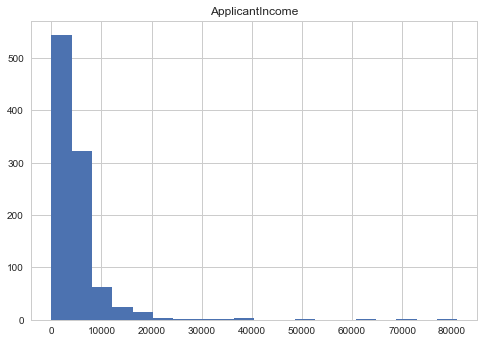

4 people who has ApplicantIncome more than 40000
2 people who has ApplicantIncome zero


In [7]:
# type of ApplicantIncome
combi.ApplicantIncome.dtype

# Histogram of ApplicantIncome
plt.figure()
combi.ApplicantIncome.hist(bins = 20)
plt.title('ApplicantIncome')
plt.show()

# Outlier Detection
print('{} people who has ApplicantIncome more than {}'.format(len(combi[combi.ApplicantIncome>40000]),40000))
print('{} people who has ApplicantIncome zero'.format(len(combi[combi.ApplicantIncome==0])))


# Use caping method to fill outlier values
combi.loc[combi.ApplicantIncome>40000,'ApplicantIncome'] = 40000


#### CoapplicantIncome

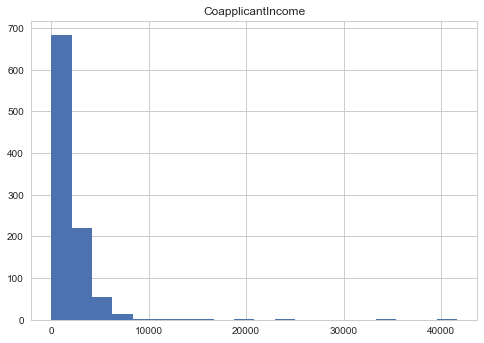

3 people has coapplicantincome more than 20000


In [8]:
# type of CoaapliantIncome
combi.CoapplicantIncome

# CoapplicantIncome plot
plt.figure()
combi.CoapplicantIncome.hist(bins=20)
plt.title('CoapplicantIncome')
plt.show()

# Outlier detection
print('{} people has coapplicantincome more than {}'.format(len(combi[combi.CoapplicantIncome>20000]),20000))

# caping to remove outlier
combi.loc[combi.CoapplicantIncome>20000,'CoapplicantIncome'] = 20000

### Create New Vartiable TotalIncome = ApplicantIncome+CoapplicantIncome

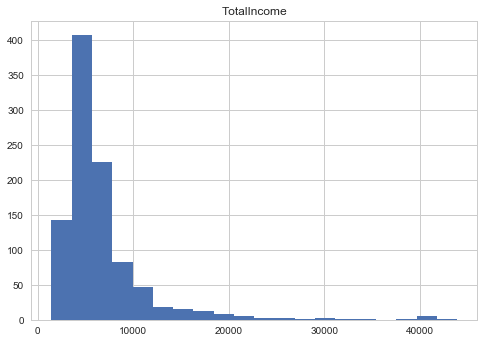

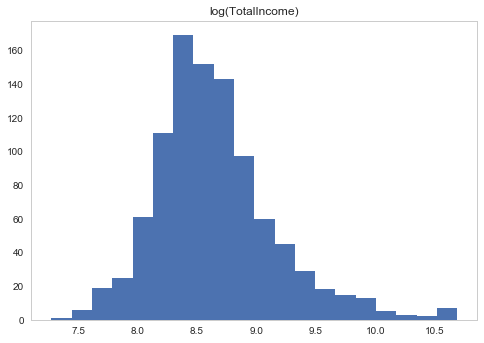

In [9]:
combi['TotalIncome'] = combi.ApplicantIncome + combi.CoapplicantIncome

plt.figure()
combi.TotalIncome.hist(bins=20)
plt.title('TotalIncome')
plt.show()

plt.figure()
np.log(combi.TotalIncome).hist(bins=20,grid=False)
plt.title('log(TotalIncome)')
plt.show()

# log transformation of TotalInocme seems more normalized and less shewed
combi.TotalIncome = np.log(combi.TotalIncome)

#### Married column

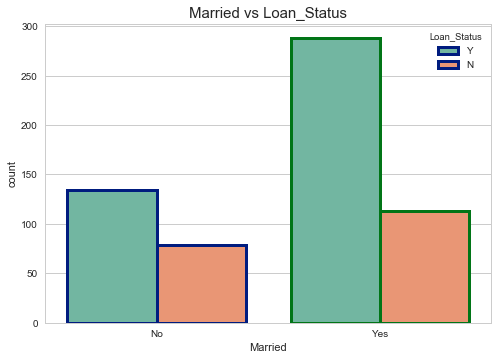

In [10]:
# Mostly people are married
combi.Married.value_counts()


# fill missing value by majority value
combi.Married.fillna(np.argmax(combi.Married.value_counts()),inplace=True)


# Plot for Married
ax = sns.countplot(combi.Married,hue=combi.Loan_Status,palette='Set2',edgecolor = sns.color_palette('dark',2),linewidth=3)
ax.set_title('Married vs Loan_Status',fontsize = 15)


#### LoanAmount

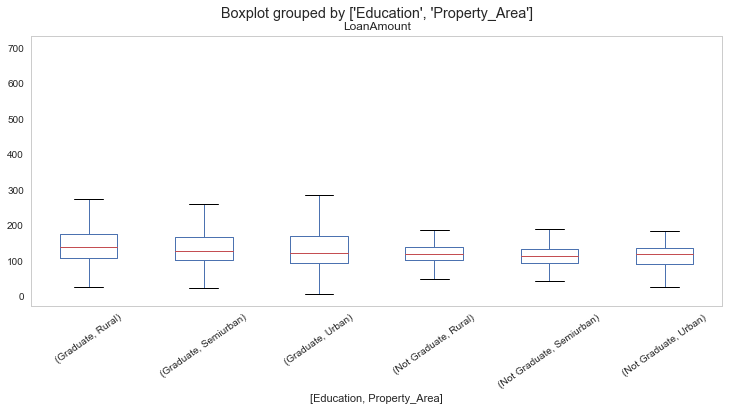

In [11]:
combi.boxplot(column=['LoanAmount'],by=['Education','Property_Area'],figsize=(12,5),grid=False,rot=35)

In [12]:
combi.pivot_table(values='LoanAmount',index =['Education','Property_Area','Married'],aggfunc=np.mean).\
                        rename(columns = {'LoanAmount':'LoanAmount(median)'})

# There are many ways to calculate
#combi.groupby(['Education','Property_Area','Married'])[['LoanAmount']].apply(lambda x: np.mean(x))
#combi.groupby(['Education','Property_Area','Married'])[['LoanAmount']].agg([np.mean,np.median])

LoanAmount(median)
Education    Property_Area Married                    
Graduate     Rural         No               145.298701
                           Yes              161.059259
             Semiurban     No               129.536842
                           Yes              158.261628
             Urban         No               120.867347
                           Yes              160.323353
Not Graduate Rural         No               107.080000
                           Yes              128.978261
             Semiurban     No               112.892857
                           Yes              122.723404
             Urban         No                98.058824
                           Yes              120.702128

In [13]:
## Missingvalue Index for LoanAmount
missIndexLoanAmount = np.where(combi.LoanAmount.isnull())
missIndexLoanAmount

(array([  0,  35,  63,  81,  95, 102, 103, 113, 127, 202, 284, 305, 322,
        338, 387, 435, 437, 479, 524, 550, 551, 605, 692, 715, 802, 861, 903], dtype=int64),)

In [14]:
combi.iloc[missIndexLoanAmount].head()

,ApplicantIncome,CoapplicantIncome,Credit_History,Dependents,Education,Gender,LoanAmount,Loan_Amount_Term,Loan_ID,Loan_Status,Married,Property_Area,Self_Employed,TotalIncome
0,5849,0.0,1.0,0,Graduate,Male,NaN,360.0,LP001002,Y,No,Urban,No,8.674026
35,2275,2067.0,1.0,0,Graduate,Male,NaN,360.0,LP001106,Y,Yes,Urban,No,8.376090
63,4945,0.0,0.0,1,Graduate,Male,NaN,360.0,LP001213,N,Yes,Rural,No,8.506132
81,2395,0.0,1.0,1,Graduate,Male,NaN,360.0,LP001266,Y,Yes,Semiurban,Yes,7.781139
95,6782,0.0,NaN,0,Graduate,Male,NaN,360.0,LP001326,N,No,Urban,NaN,8.822027


In [15]:
## Fill missing value in LoanAmount by 'Education','Property_Area','Married'

combi.LoanAmount = combi.groupby(['Education','Property_Area','Married'])[['LoanAmount']].\
                                                                transform(lambda x: x.fillna(np.mean(x)))

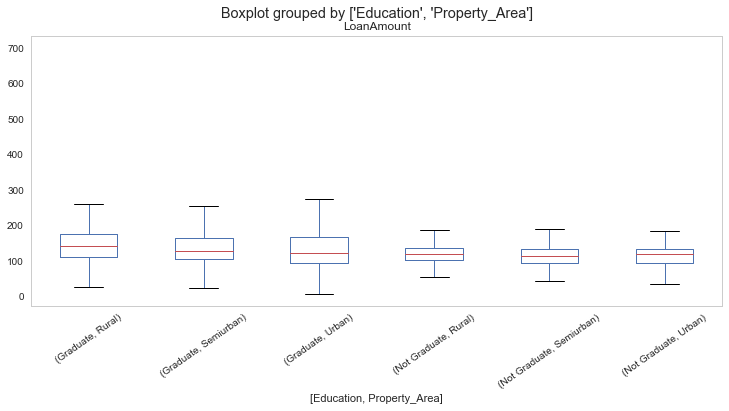

In [16]:
# Plot after missing value treatment
combi.boxplot(column=['LoanAmount'],by=['Education','Property_Area'],figsize=(12,5),grid=False,rot=35)

## Dependents

In [17]:
missIndexDependents = np.where(combi.Dependents.isnull())
missIndexDependents

(array([102, 104, 120, 226, 228, 293, 301, 332, 335, 346, 355, 435, 517,
        571, 597, 660, 684, 725, 752, 816, 861, 865, 879, 916, 926], dtype=int64),)

In [18]:
combi.iloc[missIndexDependents].head()

,ApplicantIncome,CoapplicantIncome,Credit_History,Dependents,Education,Gender,LoanAmount,Loan_Amount_Term,Loan_ID,Loan_Status,Married,Property_Area,Self_Employed,TotalIncome
102,13650,0.0,1.0,NaN,Graduate,Male,160.323353,360.0,LP001350,Y,Yes,Urban,No,9.521495
104,3816,754.0,1.0,NaN,Graduate,Male,160.000000,360.0,LP001357,Y,Yes,Urban,No,8.427268
120,5667,2667.0,1.0,NaN,Graduate,Male,180.000000,360.0,LP001426,Y,Yes,Rural,No,9.028099
226,4735,0.0,1.0,NaN,Not Graduate,Male,138.000000,360.0,LP001754,N,Yes,Urban,Yes,8.462737
228,4758,0.0,1.0,NaN,Graduate,Male,158.000000,480.0,LP001760,Y,Yes,Semiurban,No,8.467583


In [19]:
combi.Dependents.value_counts()

0     545
1     160
2     160
3+     91
Name: Dependents, dtype: int64

In [20]:
# encoding is required
combi.Dependents = combi.Dependents.str.replace('3\+','3')

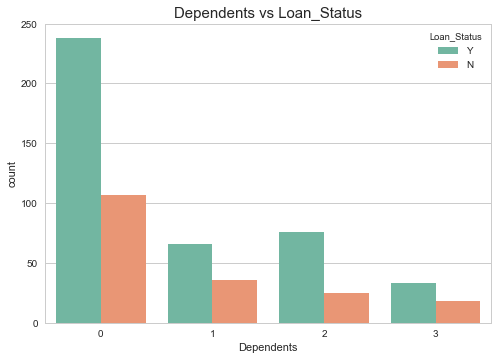

In [21]:
ax = sns.countplot(x = 'Dependents',hue = 'Loan_Status',data =combi,palette='Set2')
ax.set_title('Dependents vs Loan_Status',fontsize=15)

In [22]:
combi.groupby(['Education','Married'])['Dependents'].apply(lambda x: np.argmax(x.value_counts()))

Education     Married
Graduate      No         0
              Yes        0
Not Graduate  No         0
              Yes        0
Name: Dependents, dtype: object

In [23]:
combi.groupby(['Education','Married','Loan_Status'])['Dependents'].apply(lambda x: np.argmax(x.value_counts()))

Education     Married  Loan_Status
Graduate      No       N              0
                       Y              0
              Yes      N              0
                       Y              0
Not Graduate  No       N              0
                       Y              0
              Yes      N              0
                       Y              0
Name: Dependents, dtype: object

In [24]:
combi.Dependents = combi.Dependents.fillna(np.argmax(combi.Dependents.value_counts()))

## Gender

In [25]:
combi.Gender.value_counts()

Male      775
Female    182
Name: Gender, dtype: int64

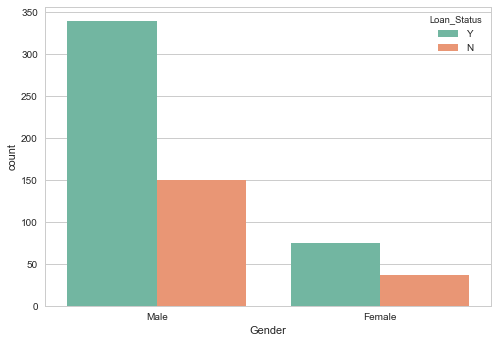

In [26]:
sns.countplot(x = 'Gender',hue ='Loan_Status',data = combi,palette='Set2')

In [27]:
combi.Gender.fillna(np.argmax(combi.Gender.value_counts()),inplace=True)

## Loan_Amount_Term

In [28]:
combi.Loan_Amount_Term.describe()

count    961.000000
mean     342.201873
std       65.100602
min        6.000000
25%      360.000000
50%      360.000000
75%      360.000000
max      480.000000
Name: Loan_Amount_Term, dtype: float64

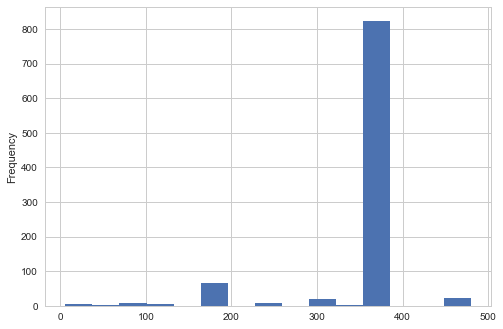

In [29]:
# plot for Loan_Amount_Term

combi.Loan_Amount_Term.plot.hist(bins= 15)

In [30]:
combi.Loan_Amount_Term.value_counts()

360.0    823
180.0     66
480.0     23
300.0     20
240.0      8
84.0       7
120.0      4
36.0       3
60.0       3
12.0       2
350.0      1
6.0        1
Name: Loan_Amount_Term, dtype: int64

In [31]:
missIndexLoan_Amount_Term = np.where(combi.Loan_Amount_Term.isnull())
missIndexLoan_Amount_Term

(array([ 19,  36,  44,  45,  73, 112, 165, 197, 223, 232, 335, 367, 421,
        423, 659, 662, 731, 743, 798, 828], dtype=int64),)

In [32]:
combi.iloc[missIndexLoan_Amount_Term].head()

,ApplicantIncome,CoapplicantIncome,Credit_History,Dependents,Education,Gender,LoanAmount,Loan_Amount_Term,Loan_ID,Loan_Status,Married,Property_Area,Self_Employed,TotalIncome
19,2600,3500.0,1.0,0,Graduate,Male,115.0,NaN,LP001041,Y,Yes,Urban,NaN,8.716044
36,1828,1330.0,0.0,0,Graduate,Male,100.0,NaN,LP001109,N,Yes,Urban,No,8.057694
44,4695,0.0,1.0,0,Not Graduate,Male,96.0,NaN,LP001136,Y,Yes,Urban,Yes,8.454253
45,3410,0.0,1.0,0,Graduate,Female,88.0,NaN,LP001137,Y,No,Urban,No,8.134468
73,4755,0.0,0.0,3,Not Graduate,Male,95.0,NaN,LP001250,N,Yes,Semiurban,No,8.466952


In [33]:
pd.pivot_table(data = combi,values='Loan_Amount_Term',index=['Education','Property_Area','Credit_History'],aggfunc=np.mean)

Loan_Amount_Term
Education    Property_Area Credit_History                  
Graduate     Rural         0.0                   346.875000
                           1.0                   343.212121
             Semiurban     0.0                   341.121951
                           1.0                   346.415094
             Urban         0.0                   349.655172
                           1.0                   338.830189
Not Graduate Rural         0.0                   341.538462
                           1.0                   348.461538
             Semiurban     0.0                   340.000000
                           1.0                   336.642857
             Urban         0.0                   349.411765
                           1.0                   322.666667

In [34]:
combi.Loan_Amount_Term = combi.groupby(['Education','Property_Area','Married','Gender'])['Loan_Amount_Term'].transform(lambda x: x.fillna(np.mean(x)))

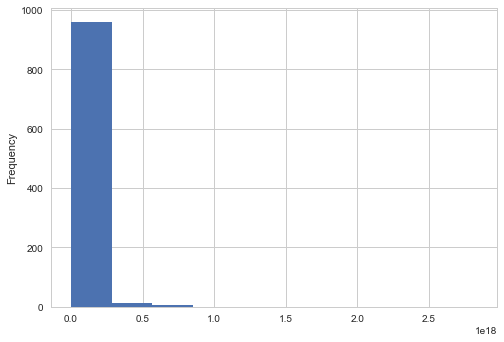

In [35]:
R = 8.35/100
combi['EMI'] = ((combi.LoanAmount * R) * ((1+R)**(combi.Loan_Amount_Term))) /(1+R**(combi.Loan_Amount_Term-1))
combi.EMI.describe()
combi.EMI.plot.hist(bins=10)

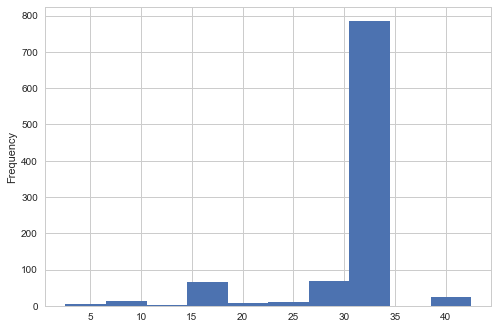

In [36]:
combi['EMI_log'] = np.log(combi.EMI)

combi['EMI_log'].plot.hist()

## Self_Employed

In [37]:
combi.Self_Employed.value_counts()

No     807
Yes    119
Name: Self_Employed, dtype: int64

In [38]:
pd.pivot_table(data = combi,values='Self_Employed',index=['Education','Property_Area','Married'],aggfunc= lambda x : np.argmax(x.value_counts()))

Self_Employed
Education    Property_Area Married              
Graduate     Rural         No                 No
                           Yes                No
             Semiurban     No                 No
                           Yes                No
             Urban         No                 No
                           Yes                No
Not Graduate Rural         No                 No
                           Yes                No
             Semiurban     No                 No
                           Yes                No
             Urban         No                 No
                           Yes                No

In [39]:
combi.Self_Employed.fillna(np.argmax(combi.Self_Employed.value_counts()),inplace=True)

## Credit_History

In [40]:
combi.Credit_History.value_counts()

1.0    754
0.0    148
Name: Credit_History, dtype: int64

In [41]:
pd.pivot_table(data = combi,values='Credit_History',index=['Education','Property_Area','Gender'],aggfunc=lambda x: sps.stats.mode(x)[0])

Credit_History
Education    Property_Area Gender                
Graduate     Rural         Female             1.0
                           Male               1.0
             Semiurban     Female             1.0
                           Male               1.0
             Urban         Female             1.0
                           Male               1.0
Not Graduate Rural         Female             1.0
                           Male               1.0
             Semiurban     Female             1.0
                           Male               1.0
             Urban         Female             1.0
                           Male               1.0

In [42]:
combi.Credit_History.fillna(1,inplace=True)

## Encoding

In [43]:
new_train = combi[combi.Loan_Status.notnull()]
new_test = combi[combi.Loan_Status.isnull()]

new_train.shape , new_test.shape

((614, 16), (367, 16))

In [44]:
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()

In [51]:
new_train_var = new_train.select_dtypes(include=['object']).columns.copy()
new_test_var = new_train.select_dtypes(include=['object']).columns.copy()

In [52]:
new_train_var

Index([], dtype='object')

In [53]:
for col in new_train_var:
    new_train.loc[:,col] = lb_make.fit_transform(new_train.loc[:,col])
    
for col in new_test_var:
    new_test.loc[:,col] = lb_make.fit_transform(new_test.loc[:,col])

In [54]:
new_test.dtypes

ApplicantIncome        int64
CoapplicantIncome    float64
Credit_History       float64
Dependents             int64
Education              int64
Gender                 int64
LoanAmount           float64
Loan_Amount_Term     float64
Loan_ID                int64
Loan_Status            int64
Married                int64
Property_Area          int64
Self_Employed          int64
TotalIncome          float64
EMI                  float64
EMI_log              float64
dtype: object

In [55]:
new_test.dtypes

ApplicantIncome        int64
CoapplicantIncome    float64
Credit_History       float64
Dependents             int64
Education              int64
Gender                 int64
LoanAmount           float64
Loan_Amount_Term     float64
Loan_ID                int64
Loan_Status            int64
Married                int64
Property_Area          int64
Self_Employed          int64
TotalIncome          float64
EMI                  float64
EMI_log              float64
dtype: object

In [56]:
predictors = new_train.drop(['Loan_ID','ApplicantIncome','CoapplicantIncome','LoanAmount','Loan_Amount_Term'],
               axis ='columns').columns

X = new_train[predictors]
y = new_train.Loan_Status
final_test_data = new_test[predictors]

# --------------------------------------------------------------------------------------------------------------

# Base Accuracy (Dummy Accuracy )

    Train score : 71.5

In [57]:
from sklearn.dummy import DummyClassifier

In [58]:
dummy_majority = DummyClassifier(strategy='most_frequent').fit(X,y)
y_dummy_prediction = dummy_majority.predict(final_test_data)

In [59]:
predicted = np.where(y_dummy_prediction==1,'Y','N')

submit_df = pd.DataFrame({'Loan_ID':test.Loan_ID,'Loan_Status':predicted})
submit_df.to_csv('dummy.csv',index=False)

# ----------------------------------------------------------------------------------------------------------

## Feature Selection Based on Random Forest

In [216]:
predictors = new_train.drop(['Loan_ID','ApplicantIncome','CoapplicantIncome','LoanAmount','Loan_Amount_Term','Loan_Status'],
               axis ='columns').columns

X = new_train[predictors]
y = new_train.Loan_Status

final_test_data = new_test[predictors]
predictors

Index(['Credit_History', 'Dependents', 'Education', 'Gender', 'Married',
       'Property_Area', 'Self_Employed', 'TotalIncome', 'EMI', 'EMI_log'],
      dtype='object')

In [217]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

In [218]:
model = RandomForestClassifier().fit(X,y)

pd.Series(model.feature_importances_,index=predictors).sort_values(ascending=False)

Credit_History    0.266244
TotalIncome       0.209099
EMI_log           0.173958
EMI               0.164430
Dependents        0.052033
Property_Area     0.051727
Self_Employed     0.024219
Married           0.023524
Education         0.017452
Gender            0.017314
dtype: float64

In [219]:
## Want  only those predictor that have impotance greater than 0.10
sfm = SelectFromModel(model, threshold=0.15)

# Train the selector
sfm.fit(X_train, y_train)

# Print the names of the most important features
for feature_list_index in sfm.get_support(indices=True):
    print(predictors[feature_list_index])

Credit_History
TotalIncome
EMI


In [161]:
# Transform the data to create a new dataset containing only the most important features
# Note: We have to apply the transform to both the training X and test X data.
X_important_train = sfm.transform(X_train)
X_important_test = sfm.transform(final_test_data)

# -------------------------------------------------------------------------------------------------------------

# Modeling (default parameter)

In [221]:
predictors = new_train.drop(['Loan_ID','ApplicantIncome','CoapplicantIncome','LoanAmount','Loan_Amount_Term','EMI'],
               axis ='columns').columns

X = new_train[predictors]
y = new_train.Loan_Status
final_test_data = new_test[predictors]

predictors

Index(['Credit_History', 'Dependents', 'Education', 'Gender', 'Loan_Status',
       'Married', 'Property_Area', 'Self_Employed', 'TotalIncome', 'EMI_log'],
      dtype='object')

In [222]:
from sklearn.model_selection import  train_test_split
from sklearn.neighbors import  KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier

In [223]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=0)

def general_classifier(model,X_train,y_train,X_test,y_test):
    training_score=[]
    testing_score=[]
    df = None
    
    if isinstance(model,KNeighborsClassifier):
        model = KNeighborsClassifier()
    elif isinstance(model,LogisticRegression):
        model = LogisticRegression()
    elif isinstance(model,DecisionTreeClassifier):
        model = DecisionTreeClassifier()
    elif isinstance(model,SVC):
        model = SVC()
    elif isinstance(model,RandomForestClassifier):
        model = RandomForestClassifier()
    elif isinstance(model,GradientBoostingClassifier):
        model = GradientBoostingClassifier()
    
    model.fit(X_train,y_train)
    training_score.append(model.score(X_train,y_train))
    testing_score.append(model.score(X_test,y_test))

    df = pd.DataFrame({'train_score':training_score,
                       'test_score':testing_score })
    df = df.sort_values(['test_score','train_score'],ascending=False).head(1)
    return(df)

In [224]:
knn = general_classifier(KNeighborsClassifier(),X_train,y_train,X_test,y_test)
logistic = general_classifier(LogisticRegression(),X_train,y_train,X_test,y_test)
tree = general_classifier(DecisionTreeClassifier(),X_train,y_train,X_test,y_test)
svm = general_classifier(SVC(),X_train,y_train,X_test,y_test)
rf = general_classifier(RandomForestClassifier(),X_train,y_train,X_test,y_test)
gbm = general_classifier(GradientBoostingClassifier(),X_train,y_train,X_test,y_test)

In [225]:
final_df = pd.DataFrame({
    'model' :['knn','logistic','tree','svm','rf','gbm'],
    'train_score':[knn.train_score[0],logistic.train_score[0],tree.train_score[0],svm.train_score[0],rf.train_score[0],gbm.train_score[0]],
    'test_score':[knn.test_score[0],logistic.test_score[0],tree.test_score[0],svm.test_score[0],rf.test_score[0],gbm.test_score[0]]
})

final_df

,model,test_score,train_score
0,knn,0.948052,0.969565
1,logistic,1.000000,1.000000
2,tree,1.000000,1.000000
3,svm,0.974026,0.997826
4,rf,1.000000,1.000000
5,gbm,1.000000,1.000000


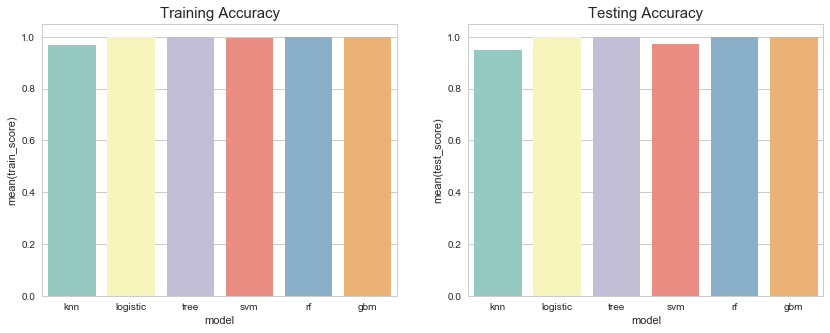

In [226]:
fig,axes = plt.subplots(1,2,figsize=(14,5))

ax1 = sns.barplot(x='model',y='train_score',data=final_df,ax=axes[0],palette='Set3')
ax1.set_title('Training Accuracy',fontsize=15)

ax2= sns.barplot(x ='model',y='test_score',data=final_df,ax=axes[1],palette='Set3')
ax2.set_title('Testing Accuracy',fontsize = 15)

# -------------------------------------------------------------------------------------------------------------


## Modeling (manual parameter tuning)

    Train score : .777

In [227]:
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import roc_curve, auc , accuracy_score, precision_score, recall_score, f1_score

def classification__model(model,X,y,cv=10):
    training_score =[]
    testing_score=[]
    auc_score=[]
    p_score=[]
    r_score=[]
    f_score=[]
    
    print('Stratified Sampling is used')
    model.fit(X,y)
    print('Accuracy :{}'.format(model.score(X,y)))
    
    skf = StratifiedShuffleSplit(n_splits=cv)
    
    for train_index,test_index in skf.split(X,y):
        X_train,X_test = X.iloc[train_index],X.iloc[test_index]
        y_train,y_test = y.iloc[train_index],y.iloc[test_index]
        
        model = model.fit(X_train,y_train)
        model_predicted = model.predict(X_test)
        
        if isinstance(model,GradientBoostingClassifier):
            y_score = model.decision_function(X_test)
            fpr, tpr, _ = roc_curve(y_test, y_score)
            auc_score.append(auc(fpr, tpr))
        
        training_score.append(accuracy_score(y_test,model_predicted))
        testing_score.append(accuracy_score(y_test,model_predicted))
        p_score.append(precision_score(y_test,model_predicted))
        r_score.append(recall_score(y_test,model_predicted))
        f_score.append(f1_score(y_test,model_predicted))
    
    if isinstance(model,GradientBoostingClassifier):
        print('Cross Validation ( AUC ):{:.3f}'.format(np.mean(auc_score)))
        
    print('Cross Validation (Training score - Accuracy ):{:.3f}'.format(np.mean(training_score)))
    print('Cross Validation (Testing score - Accuracy ):{:.3f}'.format(np.mean(testing_score)))
    print('Cross Validation ( Precision ):{:.3f}'.format(np.mean(p_score)))
    print('Cross Validation ( Recall ):{:.3f}'.format(np.mean(r_score)))
    print('Cross Validation ( F1 score ):{:.3f}'.format(np.mean(f_score)))
    
    return(model.fit(X,y))

In [235]:
predictors = new_train.drop(['Loan_ID','ApplicantIncome','CoapplicantIncome','LoanAmount','EMI','TotalIncome',
                             'Loan_Amount_Term','Loan_Status'],axis ='columns').columns

X = new_train[predictors]
y = new_train.Loan_Status

final_test_data = new_test[predictors]

predictors

Index(['Credit_History', 'Dependents', 'Education', 'Gender', 'Married',
       'Property_Area', 'Self_Employed', 'EMI_log'],
      dtype='object')

In [236]:
model_rf = RandomForestClassifier(n_estimators=100,min_samples_leaf=25,n_jobs=3,max_depth=7,random_state=1)
_ = classification__model(model_rf,X,y)

Stratified Sampling is used
Accuracy :0.8094462540716613
Cross Validation (Training score - Accuracy ):0.795
Cross Validation (Testing score - Accuracy ):0.795
Cross Validation ( Precision ):0.776
Cross Validation ( Recall ):0.993
Cross Validation ( F1 score ):0.871


In [256]:
model_tree = DecisionTreeClassifier(max_depth=10,min_samples_leaf=25,random_state=1)
_ = classification__model(model_tree,X,y)

Stratified Sampling is used
Accuracy :0.8094462540716613
Cross Validation (Training score - Accuracy ):0.821
Cross Validation (Testing score - Accuracy ):0.821
Cross Validation ( Precision ):0.815
Cross Validation ( Recall ):0.960
Cross Validation ( F1 score ):0.882


In [238]:
model_gbm = GradientBoostingClassifier(n_estimators=100,learning_rate=0.01,max_depth=7,min_samples_leaf=25,random_state=1)
_ = classification__model(model_gbm,X,y)

Stratified Sampling is used
Accuracy :0.8094462540716613
Cross Validation ( AUC ):0.751
Cross Validation (Training score - Accuracy ):0.815
Cross Validation (Testing score - Accuracy ):0.815
Cross Validation ( Precision ):0.797
Cross Validation ( Recall ):0.984
Cross Validation ( F1 score ):0.880


In [239]:
# Importance of features based on RandomForest
pd.Series(model_rf.feature_importances_,index=predictors).sort_values(ascending=False)

Credit_History    0.472689
EMI_log           0.215506
Property_Area     0.121391
Married           0.075353
Education         0.052143
Dependents        0.044930
Gender            0.011877
Self_Employed     0.006110
dtype: float64

## Apply custom cutoff on Random Forest

In [257]:
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn.model_selection import  cross_val_score

def cutoff_predict(model,X,cutoff):
    return((model.predict_proba(X)[:,1]>cutoff).astype(int))

scores_f1 =[]
scores_precision =[]
scores_recall =[]

def custom_f1(cutoff):
    def f1_cutoff(model,X,y):
        ypred = cutoff_predict(model,X,cutoff)
        return(f1_score(y,ypred))
    return(f1_cutoff)

def custom_precision(cutoff):
    def precision_cutoff(model,X,y):
        ypred = cutoff_predict(model,X,cutoff)
        return(precision_score(y,ypred))
    return(precision_cutoff)

def custom_recall(cutoff):
    def recall_cutoff(model,X,y):
        ypred = cutoff_predict(model,X,cutoff)
        return(recall_score(y,ypred))
    return(recall_cutoff)
    
for cutoff in np.arange(0.1,0.9,0.1):
    model = DecisionTreeClassifier(max_depth=10,min_samples_leaf=25,random_state=1)
    validated_f1 = cross_val_score(model,X,y,cv=10,scoring = custom_f1(cutoff))
    validated_precision = cross_val_score(model,X,y,cv=10,scoring = custom_precision(cutoff))
    validated_recall = cross_val_score(model,X,y,cv=10,scoring = custom_recall(cutoff))
    scores_f1.append(validated_f1)
    scores_precision.append(validated_precision)
    scores_recall.append(validated_recall)

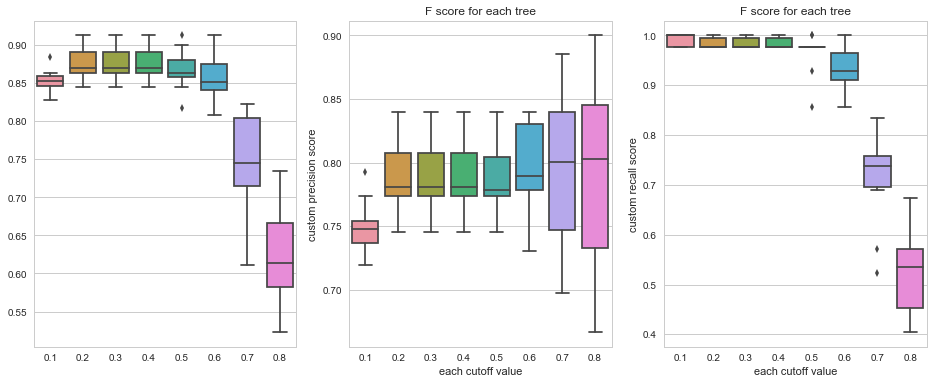

In [258]:
fig , axes = plt.subplots(1,3,figsize=(16,6))

sns.boxplot(y = scores_f1,x = np.arange(0.1,0.9,0.1),ax=axes[0])
plt.title('F score for each tree')
plt.xlabel('each cutoff value')
plt.ylabel('custom F score')

ax1 = sns.boxplot(y = scores_precision,x = np.arange(0.1,0.9,0.1),ax=axes[1])
ax1.set_title('F score for each tree')
ax1.set_xlabel('each cutoff value')
ax1.set_ylabel('custom precision score')

ax2 = sns.boxplot(y = scores_recall,x = np.arange(0.1,0.9,0.1),ax=axes[2])
ax2.set_title('F score for each tree')
ax2.set_xlabel('each cutoff value')
ax2.set_ylabel('custom recall score')

In [261]:
## Generate CSV
#predicted = model_tree.predict(final_test_data[predictors])
predicted = cutoff_predict(model_tree,final_test_data,0.4)
predicted = np.where(predicted==1,'Y','N')

submit_df = pd.DataFrame({'Loan_ID':test.Loan_ID,'Loan_Status':predicted})
submit_df.to_csv('manual_tree.csv',index=False)

# -----------------------------------------------------------------------------------------------------

## GridSearch

    Test Score : .777

In [91]:
from sklearn.model_selection import  GridSearchCV

In [79]:
predictors = new_train.drop(['Loan_ID','ApplicantIncome','CoapplicantIncome','LoanAmount',
                             'Loan_Amount_Term','Loan_Status'],axis ='columns').columns

X = new_train[predictors]
y = new_train.Loan_Status

final_test_data = new_test[predictors]

predictors

Index(['Credit_History', 'Dependents', 'Education', 'Gender', 'Married',
       'Property_Area', 'Self_Employed', 'TotalIncome', 'EMI'],
      dtype='object')

In [89]:
grid_rf = {'max_depth':np.arange(1,15,1),'n_estimators':np.arange(100,600,200),'min_samples_leaf':[25,35,50]}
grid_gbm = {'max_depth':np.arange(1,15,1),'n_estimators':np.arange(100,600,200),
            'min_samples_leaf':[25,35,50],'learning_rate':[.1,.01,.001]}
grid_tree = {'max_depth':np.arange(1,15,1),'min_samples_leaf':[25,35,50]}

In [92]:
rf_mod = GridSearchCV(RandomForestClassifier(),param_grid=grid_rf,
                        n_jobs=3,scoring='roc_auc',return_train_score=False).fit(X,y)

In [93]:
gbm_mod = GridSearchCV(GradientBoostingClassifier(),param_grid=grid_gbm,
                        n_jobs=3,scoring='roc_auc',return_train_score=False).fit(X,y)

In [94]:
tree_mod = GridSearchCV(DecisionTreeClassifier(),param_grid=grid_tree,
                        n_jobs=3,scoring='roc_auc',return_train_score=False).fit(X,y)

In [100]:
print('--- Random Forest ---')
print('Best Parameter :{}'.format(rf_mod.best_params_))
print('AUC :{}'.format(rf_mod.best_score_))

--- Random Forest ---
Best Parameter :{'max_depth': 11, 'min_samples_leaf': 25, 'n_estimators': 300}
AUC :0.7410375522055451


In [99]:
print('--- GBM ---')
print('Best Parameter :{}'.format(gbm_mod.best_params_))
print('AUC :{}'.format(gbm_mod.best_score_))

--- GBM ---
Best Parameter :{'learning_rate': 0.1, 'max_depth': 1, 'min_samples_leaf': 50, 'n_estimators': 500}
AUC :0.7459399617668122


In [98]:
print('--- Decision Tree ---')
print('Best Parameter :{}'.format(tree_mod.best_params_))
print('AUC :{}'.format(tree_mod.best_score_))

--- Decision Tree ---
Best Parameter :{'max_depth': 4, 'min_samples_leaf': 25}
AUC :0.7115376291422036


In [129]:
# Generate CSV
predicted = tree_mod.predict(final_test_data[predictors])
predicted = np.where(predicted==1,'Y','N')

submit_df = pd.DataFrame({'Loan_ID':test.Loan_ID,'Loan_Status':predicted})
submit_df.to_csv('grid_tree.csv',index=False)

In [130]:
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [131]:
model = RandomForestClassifier().fit(X_train,y_train)

In [133]:
model_prob = model.predict_proba(X_test)
model_predicted = model.predict(X_test)

In [139]:
# Precission Vs Recall curve Logistic regression
from sklearn.metrics import precision_recall_curve, log_loss

precision, recall, thresholds = precision_recall_curve(y_test, model_predicted)